In [43]:
import numpy as np
import math
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FuncFormatter
from matplotlib.ticker import MultipleLocator

In [5]:
mapset_path = '../dataset/Analiza zbioru danych/mapset'
a_star_path = 'dataset/Auto_mapset/A_star'

In [39]:

def slope_analyze(ds):
    iter_range = len(ds.index)
    for i in range(iter_range):
        dem_path = ds.iloc[i]['DEM path']
        with open(dem_path, 'rb') as f:
            slope = np.load(f)
        slope_arr = slope.flatten()
     #   dem_diff = np.max(dem_arr)-np.mean(dem_arr)
        if i == 0:
            slope_hist = slope_arr
        else:
            slope_hist=np.append(slope_hist, slope_arr)
    return slope_hist

def dem_analyze(ds):
    iter_range = len(ds.index)
    for i in range(iter_range):
        dem_path = ds.iloc[i]['DEM path']
        with open(dem_path, 'rb') as f:
            dem = np.load(f)
        dem_arr = dem.flatten()
        dem_diff = np.max(dem_arr)-np.min(dem_arr)
        if i == 0:
            dem_hist = dem_diff
        else:
            dem_hist=np.append(dem_hist, dem_diff)
    return dem_hist
   
def calc_dist(ds, res=1.5):
    s_x = ds['Start x coord'].to_numpy(dtype=np.float32, copy=True)
    s_y = ds['Start y coord'].to_numpy(dtype=np.float32, copy=True)
    g_x = ds['Goal x coord'].to_numpy(dtype=np.float32, copy=True)
    g_y = ds['Goal y coord'].to_numpy(dtype=np.float32, copy=True)
    
    s = np.stack((s_x,s_y), axis=1)
    g = np.stack((g_x,g_y), axis=1)
    
    dist = np.sqrt(np.power((g[:,0]-s[:,0]),2)+np.power((g[:,1]-s[:,1]),2))*res
    return dist

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    global n

    s = str(round(100 * y, 3))
    print (y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
    
def plot_histograms(ds, save_fig=True, export_path='../dataset/Analiza zbioru danych/figures', name='mapset_500x500'):

    dem_hist = dem_analyze(ds)
    slope_hist = slope_analyze(ds)
    dist = calc_dist(ds)

    with plt.style.context('ggplot'):
        fig, ax = plt.subplots(figsize=(16,12), dpi=144)
        plt.clf()
    #    fig.suptitle('Analiza własności terenowych map w zbiorze', fontsize=14)
        ax_1 = fig.add_subplot(221)
        n, bins, patches = ax_1.hist(dem_hist, bins=20, facecolor = '#2ab0ff', edgecolor='white', linewidth=0.5)
        plt.xlabel('Zróżnicowanie wysokości [m]', fontsize=9)
        plt.ylabel('Ilość przypadków testowych [-]', fontsize=9)
        plt.grid(True,'minor', 'x',  linewidth=0.2, color='white',linestyle='-')
        plt.grid(True,'major')
        plt.title('Zróżnicowanie wysokości terenu', fontsize=10)
        ax_1.minorticks_on()

        ax_2 = fig.add_subplot(212)
        n, bins, patches = ax_2.hist(slope_hist, density=True, bins=20, facecolor = '#E42AFF', edgecolor='white', linewidth=0.5)
        plt.xlabel('Odchylenie od średniej wysokości [m]', fontsize=9)
        plt.grid(True,'minor', 'x',  linewidth=0.2, color='white',linestyle='-')
        plt.grid(True,'major')
        plt.ylabel('Ilość pikseli [%]', fontsize=9)
        ax_2.minorticks_on()
     #   plt.gca().yaxis.set_major_formatter(PercentFormatter(100))
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y*10)))
        plt.title('Charakter rzeźby terenu', fontsize=10)
        
        ax_3 = fig.add_subplot(222)
        n, bins, patches = ax_3.hist(dist, bins=10, facecolor = '#FF792A', edgecolor='white', linewidth=0.5)
        plt.grid(True,'minor', 'x',  linewidth=0.2, color='white',linestyle='-')
        plt.grid(True,'major')
        plt.ylabel('Ilość przypadków testowych [-]', fontsize=9)
        plt.xlabel('Odległość punktów na trasie [m]', fontsize=9)
        ax_3.minorticks_on()
        ax_3.grid(True,which='minor', axis='x',  linewidth=0.3, color='white',linestyle='-')
#         ax_3.yaxis.set_major_locator(MultipleLocator(1))
#         ax_3.xaxis.set_major_locator(MultipleLocator(300))
        plt.title('Odległość zadanych punktów startu/mety', fontsize=10)
        
        if save_fig:
            name = name + '.jpg'
            fig_path = os.path.join(export_path, name)
            plt.savefig(fig_path)
            plt.close()

In [40]:
def get_mapsets(mapset_path):
    search_exp = os.path.join(mapset_path, '*.csv')
    files = []
    for file in glob.glob(search_exp):
        files.append(file)
    return files

def iterate_over_mapset(mapset_path):
    files = get_mapsets(mapset_path)
    
    for file in files:
        file_name = os.path.split(file)[1]
        file_name = os.path.splitext(file_name)[0]
        ds = pd.read_csv(file)
        plot_histograms(ds, save_fig=True, export_path='../dataset/Analiza zbioru danych/figures', name=file_name)

In [41]:
iterate_over_mapset(mapset_path)

In [2]:
def join_mapsets(mapset_path, export=False, name='mapset.csv'):
    files = get_mapsets(mapset_path)
    i = 0
    for file in files:
        file_name = os.path.split(file)[1]
        file_name = os.path.splitext(file_name)[0]
        ds = pd.read_csv(file)
        ds['Resolution']=1.5
        if i==0:
            dataset = ds
        else:
            dataset = pd.concat([dataset, ds], ignore_index=True)
        i+=1
    if export:
        name = os.path.join(mapset_path, name)
        dataset.to_csv(name, index=False)
    return dataset
       # plot_histograms(ds, save_fig=True, export_path='../dataset/Analiza zbioru danych/figures', name=file_name)

In [3]:
ds = join_mapsets(mapset_path, True)
ds

NameError: name 'mapset_path' is not defined

In [2]:
import sys
sys.path.append("../rover_planner")

import mapping
def iterate_ds_maplots(table_path):
    out_path = '../dataset/Analiza zbioru danych/figures/maps'
    table = pd.read_csv(table_path)
    iter_range = len(table. index)
    for i in range(iter_range):
        dem_path = table.iloc[i]['DEM path']
        og_path = table.iloc[i]['Occupancy grid path']
        sx = table.iloc[i]['Start x coord']
        sy = table.iloc[i]['Start y coord']
        gx = table.iloc[i]['Goal x coord']
        gy = table.iloc[i]['Goal y coord']
        res = table.iloc[i]['Resolution']
        name_idx = table.iloc[i]['Name_idx']
        
        step = table.iloc[i]['Map height']
        with open(dem_path, 'rb') as f:
            img = np.load(f)
            img = np.asarray(img, dtype=np.float32)
        with open(og_path, 'rb') as f:
            og = np.load(f)
            og = og*-255
        slope = mapping.calculate_slope(img)
        safe_slope = mapping.safe_area(slope)
        
        max_height = abs((np.min(img))) + 10
        slope_plot_name = mapping.analyze_slope_map(og, True, out_path=out_path, name_idx=name_idx, step=math.ceil(step/10))
        start_end_name = mapping.plot_start_end(og,(sy,sx),(gy,gx), export_img=True, 
                                        out_path=out_path, name_idx=name_idx, step=math.ceil(step/10), res=1.5)
        mesh_plot_name = mapping.plot_mesh(img, export_img=True, out_path=out_path, name_idx=name_idx, height=max_height)
        

In [44]:
table_path = '../dataset/Analiza zbioru danych/mapset/mapset.csv'
ds = pd.read_csv(table_path)
#iterate_ds_maplots(table_path)

In [45]:
ds

,Name_idx,Occupancy grid path,DEM path,Slope aspect path,Start x coord,Start y coord,Goal x coord,Goal y coord,Resolution,Map width,Map height
0,X_1000_2000_Y_12000_13000,../dataset/Auto_mapset2\OG_X_1000_2000_Y_12000...,../dataset/Auto_mapset2\DEM_X_1000_2000_Y_1200...,../dataset/Auto_mapset2\SLOPE_X_1000_2000_Y_12...,378,542,836,495,1.5,996,996
1,X_8000_9000_Y_1000_2000,../dataset/Auto_mapset2\OG_X_8000_9000_Y_1000_...,../dataset/Auto_mapset2\DEM_X_8000_9000_Y_1000...,../dataset/Auto_mapset2\SLOPE_X_8000_9000_Y_10...,194,569,579,573,1.5,996,996
2,X_11000_12000_Y_1000_2000,../dataset/Auto_mapset2\OG_X_11000_12000_Y_100...,../dataset/Auto_mapset2\DEM_X_11000_12000_Y_10...,../dataset/Auto_mapset2\SLOPE_X_11000_12000_Y_...,115,638,655,775,1.5,996,996
3,X_16000_17000_Y_2000_3000,../dataset/Auto_mapset2\OG_X_16000_17000_Y_200...,../dataset/Auto_mapset2\DEM_X_16000_17000_Y_20...,../dataset/Auto_mapset2\SLOPE_X_16000_17000_Y_...,565,423,4,56,1.5,996,996
4,X_12000_13000_Y_1000_2000,../dataset/Auto_mapset2\OG_X_12000_13000_Y_100...,../dataset/Auto_mapset2\DEM_X_12000_13000_Y_10...,../dataset/Auto_mapset2\SLOPE_X_12000_13000_Y_...,605,897,681,413,1.5,996,996
...,...,...,...,...,...,...,...,...,...,...,...
200,X_9500_10000_Y_12500_13000,../dataset/Auto_mapset\OG_X_9500_10000_Y_12500...,../dataset/Auto_mapset\DEM_X_9500_10000_Y_1250...,../dataset/Auto_mapset\SLOPE_X_9500_10000_Y_12...,31,357,208,393,1.5,496,496
201,X_25000_25500_Y_7000_7500,../dataset/Auto_mapset\OG_X_25000_25500_Y_7000...,../dataset/Auto_mapset\DEM_X_25000_25500_Y_700...,../dataset/Auto_mapset\SLOPE_X_25000_25500_Y_7...,107,45,308,286,1.5,496,496
202,X_25500_26000_Y_7000_7500,../dataset/Auto_mapset\OG_X_25500_26000_Y_7000...,../dataset/Auto_mapset\DEM_X_25500_26000_Y_700...,../dataset/Auto_mapset\SLOPE_X_25500_26000_Y_7...,237,82,0,101,1.5,496,496
203,X_500_1000_Y_12000_12500,../dataset/Auto_mapset\OG_X_500_1000_Y_12000_1...,../dataset/Auto_mapset\DEM_X_500_1000_Y_12000_...,../dataset/Auto_mapset\SLOPE_X_500_1000_Y_1200...,127,331,237,353,1.5,496,496


In [51]:
ds.nunique()

Name_idx               163
Occupancy grid path    163
DEM path               163
Slope aspect path      163
Start x coord          166
Start y coord          171
Goal x coord           162
Goal y coord           162
Resolution               1
Map width                4
Map height               4
dtype: int64

In [54]:
ds['Map width'].value_counts()

246     100
496      89
996      15
1996      1
Name: Map width, dtype: int64

In [77]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

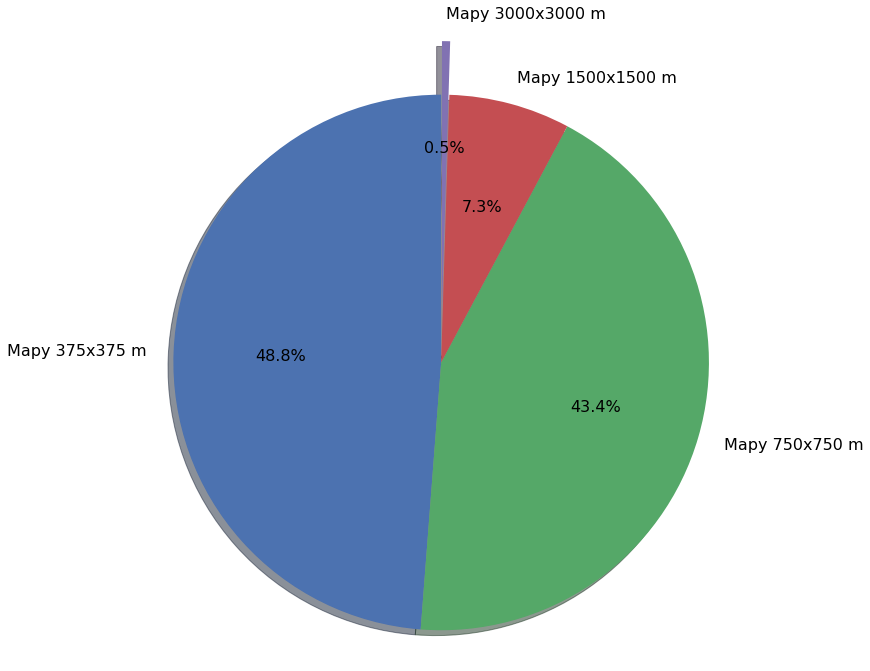

In [91]:
labels = ['Mapy 375x375 m', 'Mapy 750x750 m', 'Mapy 1500x1500 m', 'Mapy 3000x3000 m']
sizes = [100, 89, 15, 1]
explode = (0, 0, 0, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

with plt.style.context('seaborn-deep'):
    fig1, ax1 = plt.subplots(figsize=(12,12))
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 16})
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.savefig('../dataset/Analiza zbioru danych/figures/pie.jpg')
    plt.show()